In [31]:
import importlib
import sys
from urllib.request import urlretrieve

# Install drake (and underactuated).
if 'google.colab' in sys.modules and importlib.util.find_spec('underactuated') is None:
    urlretrieve(f"http://underactuated.csail.mit.edu/scripts/setup/setup_underactuated_colab.py",
                "setup_underactuated_colab.py")
    from setup_underactuated_colab import setup_underactuated
    setup_underactuated(underactuated_sha='15cfd96b0bdfd1b0c67597c24f91907776c02a6d', drake_version='0.27.0', drake_build='release')

server_args = []
if 'google.colab' in sys.modules:
  server_args = ['--ngrok_http_tunnel']
# Start a single meshcat server instance to use for the remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc_planar, zmq_url_planar, web_url_planar = start_zmq_server_as_subprocess(server_args=server_args)
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)

import numpy as np
from ipywidgets import FloatSlider, ToggleButton
from IPython.display import display, SVG, HTML
import pydot
import matplotlib.pyplot as plt

import pydrake.all
from pydrake.all import (
    MultibodyPlant, DiagramBuilder, LinearQuadraticRegulator, Saturation, SceneGraph, Simulator, 
    WrapToSystem, AddMultibodyPlantSceneGraph, Parser, MathematicalProgram, eq, PiecewisePolynomial,
    SnoptSolver, TrajectorySource, MultibodyPositionToGeometryPose, PlanarSceneGraphVisualizer,VectorSystem ,LogOutput
)
from pydrake.examples.acrobot import AcrobotPlant, AcrobotGeometry
from pydrake.systems.jupyter_widgets import WidgetSystem
from pydrake.common.containers import namedview
from underactuated import FindResource, ManipulatorDynamics
from underactuated.jupyter import running_as_notebook


## Problem Description

We want to write a nonlinear optimization for the ball balancing bot. In order to complete our trajectory optimization, we will use `MathematicalProgram`.

**maybe write more later if we submit the notebook

## Parse the `urdf` and Get the `MultibodyPlant`

We start by defining a couple of physical parameters that we will need below.

In [32]:
ballbot_urdf = """
<?xml version="1.0"?>

<robot xmlns="http://drake.mit.edu"
 xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
 name="BallBot">

  <link name="ground">
    <visual>
      <origin xyz="0 0 -5" rpy="0 0 0" />
      <geometry>
        <box size="1000 1000 10" />
      </geometry>
      <material>
        <color rgba="0.93 .74 .4 1" />
      </material>
    </visual>
  </link>

  <joint name="ground_weld" type="fixed">
    <parent link="world" />
    <child link="ground" />
  </joint>

  <link name="ball">
    <inertial>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <mass value="5" />
      <inertia ixx=".2" ixy="0" ixz="0" iyy="0.2" iyz="0" izz="0.2" />
    </inertial>
    <visual>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <geometry>
        <sphere radius=".1" />
      </geometry>
      <material>
        <color rgba="0.25 0.52 0.96 1" />
      </material>
    </visual>
  </link>

  <link name="bot">
    <inertial>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <mass value="4" />
      <inertia ixx="0.10" ixy="0" ixz="0" iyy="0.18" iyz="0" izz="0.1" />
    </inertial>
    <visual>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <geometry>
         <cylinder length=".1" radius=".12" />
      </geometry>
      <material>
        <color rgba=".61 .63 .67 1" />
      </material>
    </visual>
  </link>
  
  <joint name="x" type="prismatic">
    <parent link="world" />
    <child link="ball" />
    <origin xyz="0 0 .1" />
    <axis xyz="1 0 0" />
    <dynamics damping="0.1" />
  </joint>
   

  <joint name="theta1" type="continuous">
    <parent link="ball" />
    <child link="bot" />
    <origin xyz="0 0 0" />
    <axis xyz="0 1 0" />
    <dynamics damping="0.1" />
  </joint>


  <transmission type="SimpleTransmission" name="ball_torque">
    <actuator name="torque" />
    <joint name="theta1" />
    <mechanicalReduction>1</mechanicalReduction>
  </transmission>

  <transmission type="SimpleTransmission" name="ball_force">
    <actuator name="force" />
    <joint name="x" />
    <mechanicalReduction>.1</mechanicalReduction>
  </transmission>
</robot>
"""

In [33]:
# parse urdf and create the MultibodyPlant
ballbot_2D = MultibodyPlant(time_step=0)
Parser(ballbot_2D).AddModelFromString(ballbot_urdf, "urdf")
ballbot_2D.Finalize()

# overwrite MultibodyPlant with its autodiff copy
ballbot_2D = ballbot_2D.ToAutoDiffXd() 

# number of configuration variables
nq = ballbot_2D.num_positions()  # Returns the size of the multibody system state vector x = [q v]. This will be num_positions() plus num_velocities()

# number of components of the contact forces
nf = 2

In [34]:
print(nq)

2


## Helper Functions

In [35]:
def ballbot2D_dynamics(vars):
    split_at = [nq, 2 * nq, 3 * nq]
    q, qd, qdd, u = np.split(vars, split_at)
    
    # set compass gait state
    context = ballbot_2D.CreateDefaultContext()
    ballbot_2D.SetPositions(context, q)
    ballbot_2D.SetVelocities(context, qd)
    ballbot_2D.get_actuation_input_port().FixValue(context, u)
    
    # matrices for the manipulator equations
    M, Cv, tauG, B, tauExt = ManipulatorDynamics(ballbot_2D,q,qd)
    # print(M.dot(qdd) + Cv - tauG- ballbot_2D.MakeActuationMatrix()@u)
    theta = q[1]
    # if theta > 0:
    #   print(theta)

    # return violation of the manipulator equations
    return M.dot(qdd) + Cv - tauG -B@u - tauExt

## The Trajectory Optimization Problem

We start by setting some parameters of our optimization problem.

In [36]:
# time steps in the trajectory optimization
T = 50

# minimum and maximum time interval is seconds
h_min = .005
h_max = .05

# goal, start positions
goal = [0, 0]
start = [0, -.7]

max_control = 1

In [37]:
# initialize program
prog = MathematicalProgram()

# vector of the time intervals
# (distances between the T + 1 break points)
h = prog.NewContinuousVariables(T, name='h')

# system configuration, generalized velocities, and accelerations
q = prog.NewContinuousVariables(rows=T+1, cols=nq, name='q')
qd = prog.NewContinuousVariables(rows=T+1, cols=nq, name='qd')
qdd = prog.NewContinuousVariables(rows=T, cols=nq, name='qdd')

# actuation
u = prog.NewContinuousVariables(rows=T, cols=nq, name='u')

Here are part of the constraints of the optimization problem:


1.   Time steps need to be bounded between h_min and h_max
2.   Map configurations, velocities, accelerations to each other using the Euler method
3.   Something about dynamics
4.   Want the thing on top to be horizonal at the end (theta1 = 0, theta2 = 0)
5.   Can add an angle bound (like it can't be more than 15 deg away from horizontal)



In [38]:
# 1. lower and upper bound on the time steps for all t
prog.AddBoundingBoxConstraint([h_min] * T, [h_max] * T, h)

# 2. link the configurations, velocities, and accelerations
# uses implicit Euler method, https://en.wikipedia.org/wiki/Backward_Euler_method
for t in range(T):
    prog.AddConstraint(eq(q[t+1], q[t] + h[t] * qd[t+1]))
    prog.AddConstraint(eq(qd[t+1], qd[t] + h[t] * qdd[t]))

# 3. drake dynamics
for t in range(T):
  vars = np.concatenate((q[t], qd[t], qdd[t], u[t]))
  prog.AddConstraint(ballbot2D_dynamics, lb=[0]*nq, ub=[0]*nq, vars=vars)
  prog.AddLinearConstraint(u[t][0] == u[t][1])
  prog.AddLinearConstraint(u[t][0] <= max_control)
  prog.AddLinearConstraint(u[t][0] >= -1* max_control)

  # residual = ballbot2D_dynamics(vars)
  # prog.AddLinearConstraint(residual[0] == 0)
  # prog.AddLinearConstraint(residual[1] == 0)
# vars = np.concatenate((q[-1], qd[-1], qd_post, imp))
# prog.AddConstraint(reset_velocity_heelstrike, lb=[0]*(nq+nf), ub=[0]*(nq+nf), vars=vars)    

# 4. horizontal at end
# q = [x, theta1]
prog.AddLinearConstraint(q[-1][1] == goal[1])

# at the origin at the end
prog.AddLinearConstraint(q[-1][0] == goal[0])

# give start position
prog.AddLinearConstraint(q[0][0] == start[0])
prog.AddLinearConstraint(q[0][1] == start[1])

Here we set the initial guess for our optimization problem.

For the time steps `h` we just initialize them to their maximal value `h_max` (somewhat an arbitrary decision, but it works).

For the robot configuration `q`, we interpolate between the initial value `q0_guess` and the final value `- q0_guess`.
In our implementation, the value given below for `q0_guess` made the optimization converge.
But, if you find the need, feel free to tweak this parameter.
The initial guess for the velocity and the acceleration is obtained by differentiating the one for the position.

The normal force `f` at the stance foot is equal to the total `weight` of the robot.

All the other optimization variables are initialized at zero.
(Note that, if the initial guess for a variable is not specified, the default value is zero.)

In [39]:
# vector of the initial guess
initial_guess = np.empty(prog.num_vars())

# initial guess for the time step
h_guess = h_max
prog.SetDecisionVariableValueInVector(h, [h_guess] * T, initial_guess)

# linear interpolation of the configuration
q0_guess = np.array([0, .15])
q_guess_poly = PiecewisePolynomial.FirstOrderHold(
    [0, T * h_guess],
    np.column_stack((q0_guess, - q0_guess))
)
qd_guess_poly = q_guess_poly.derivative()
qdd_guess_poly = q_guess_poly.derivative()

# set initial guess for configuration, velocity, and acceleration
q_guess = np.hstack([q_guess_poly.value(t * h_guess) for t in range(T + 1)]).T
qd_guess = np.hstack([qd_guess_poly.value(t * h_guess) for t in range(T + 1)]).T
qdd_guess = np.hstack([qdd_guess_poly.value(t * h_guess) for t in range(T)]).T
prog.SetDecisionVariableValueInVector(q, q_guess, initial_guess)
prog.SetDecisionVariableValueInVector(qd, qd_guess, initial_guess)
prog.SetDecisionVariableValueInVector(qdd, qdd_guess, initial_guess)

We can finally solve the problem! Be sure that the solver actually converged: you can check this by looking at the variable result.is_success() (printed below).

In [40]:
# solve mathematical program with initial guess
solver = SnoptSolver()
result = solver.Solve(prog, initial_guess)

# ensure solution is found
print(f'Solution found? {result.is_success()}.')

Solution found? True.


In the following cell we retrieve the optimal value of the decision variables.

In [41]:
# get optimal solution
h_opt = result.GetSolution(h)
q_opt = result.GetSolution(q)
qd_opt = result.GetSolution(qd)
qdd_opt = result.GetSolution(qdd)
us_opt = result.GetSolution(u)
# stack states
x_opt = np.hstack((q_opt, qd_opt))

Here we are going to do something dumb

## Animate the Result

Here we quickly build a Drake diagram to animate the result we got from trajectory optimization: useful for debugging your code and to be sure that everything looks good.

In [42]:
# interpolate state values for animation
time_breaks_opt = np.array([sum(h_opt[:t]) for t in range(T+1)])
x_opt_poly = PiecewisePolynomial.FirstOrderHold(time_breaks_opt, x_opt.T)

# parse urdf with scene graph
ballbot = MultibodyPlant(time_step=0)
scene_graph = SceneGraph()
ballbot.RegisterAsSourceForSceneGraph(scene_graph)
Parser(ballbot).AddModelFromString(ballbot_urdf, "urdf")
ballbot.Finalize()

# build block diagram and drive system state with
# the trajectory from the optimization problem
builder = DiagramBuilder()
source = builder.AddSystem(TrajectorySource(x_opt_poly))
builder.AddSystem(scene_graph)
pos_to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(ballbot, input_multibody_state=True))
builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
builder.Connect(pos_to_pose.get_output_port(), scene_graph.get_source_pose_port(ballbot.get_source_id()))

# add visualizer
xlim = [-.75, .75]
ylim = [-.2, 1.5]
visualizer = builder.AddSystem(PlanarSceneGraphVisualizer(scene_graph, xlim=xlim, ylim=ylim, show=False))
builder.Connect(scene_graph.get_pose_bundle_output_port(), visualizer.get_input_port(0))
simulator = Simulator(builder.Build())

# generate and display animation
visualizer.start_recording()
simulator.AdvanceTo(x_opt_poly.end_time())
ani = visualizer.get_recording_as_animation()
HTML(ani.to_jshtml())

In [58]:
# we just want to look at the h and fix this stuff and find the 
class Policy(VectorSystem):

    def __init__(self, h_opt, us):
        # 4 inputs: ball bot state [q, q_dot]
        # 1 output: control torque [u]
        VectorSystem.__init__(self, 4,  1)
        self.time = np.cumsum(np.insert(h_opt,0,0))
        print(self.time)
        self.us = np.append(us[:,0],0) # actions over time
        #self.A = torch.tensor(sys.A(),dtype=torch.float)
        #self.B = torch.tensor(sys.B(),dtype = torch.float)
        print(self.us)
        

    def DoCalcVectorOutput(self, context, state, unused, torque):
        
        
      
        #self.laststate = Xnext1[:,ind[0],:,:].unsqueeze(1);
        torque[:] = np.interp(context.get_time(),self.time,self.us)
        #print(torque)

def BallBot_sys():
  builder = DiagramBuilder()
  ballbot, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
  Parser(ballbot).AddModelFromString(ballbot_urdf, "urdf")
  ballbot.set_name("ballbot")
  ballbot.Finalize()

  B = np.array([[1],[1]])

  gain = builder.AddSystem(pydrake.systems.primitives.MatrixGain(B))
  gain.set_name("Actuator Mapping")

  builder.Connect(gain.get_output_port(),ballbot.get_actuation_input_port())
  builder.ExportInput(gain.get_input_port(),"torque")
  builder.ExportOutput(ballbot.get_state_output_port(), "continuous_state")
  builder.ExportOutput(scene_graph.get_query_output_port(), "query")
  builder.ExportOutput(scene_graph.get_pose_bundle_output_port(), "pose")

  return builder.Build(),scene_graph

[0.         0.005      0.05065349 0.09480912 0.13893645 0.18283291
 0.22161818 0.26126007 0.30324013 0.34383229 0.3873385  0.42853356
 0.46876459 0.50842632 0.54836224 0.58611272 0.63217129 0.68217129
 0.73217129 0.78217129 0.83217129 0.88217129 0.93217129 0.98217129
 1.03217129 1.08217129 1.13217129 1.18215674 1.23214108 1.28212537
 1.33196241 1.38167555 1.43131969 1.48093234 1.53054634 1.58019484
 1.62991229 1.67973293 1.7296876  1.7796876  1.8296876  1.8796876
 1.9296876  1.9796876  2.0296876  2.07965675 2.12955783 2.17014391
 2.17587421 2.18141725 2.18666553]
[ 9.88850399e-01  9.84929363e-01  9.85747621e-01  9.87312934e-01
  9.88116373e-01  9.97753890e-01  9.69720004e-01  9.20425188e-01
  8.69847233e-01  8.24171235e-01  7.75105789e-01  7.30031485e-01
  6.87403106e-01  6.46727371e-01  5.86313820e-01  5.45571498e-01
  5.00239184e-01  4.54712986e-01  4.12095499e-01  3.72315985e-01
  3.35288601e-01  3.00915330e-01  2.69088678e-01  2.39694127e-01
  2.12612317e-01  1.87720980e-01  1.6489

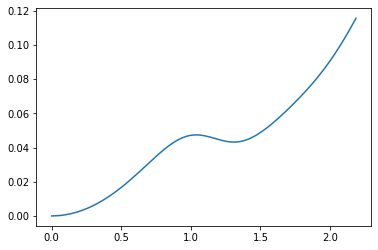

In [63]:
#testing stuff
policy = Policy(h_opt,us_opt)

builder = DiagramBuilder() # instantiate a diagram builder
ballbotsystem,scene_graph = BallBot_sys()
ballbotsystem.set_name("System BallBot")

plant = builder.AddSystem(ballbotsystem) # add a sub-system to it
vi_policy = builder.AddSystem(policy)
builder.Connect(plant.GetOutputPort("continuous_state"), vi_policy.get_input_port(0)) # connecting inputs/outputs of two sub-systems in our diagram
builder.Connect(vi_policy.get_output_port(0), plant.get_input_port())
log = LogOutput(plant.get_output_port(0),builder)
visualizer = builder.AddSystem(
PlanarSceneGraphVisualizer(scene_graph, xlim=[-3., 2.], ylim=[-.4, 1.5], show=False))


builder.Connect(plant.GetOutputPort("pose"), visualizer.get_input_port(0))

diagram = builder.Build() # finish building the diagram

# Simulate the system
simulator = Simulator(diagram)
simulator.get_mutable_context().SetContinuousState([0,-.7,0,0]) # set the initial state
# generate and display animation
visualizer.start_recording()
simulator.AdvanceTo(x_opt_poly.end_time())
ani = visualizer.get_recording_as_animation()

HTML(ani.to_jshtml())
times = log.sample_times()

verticies = np.vstack([times,log.data()[0,:]])

ax1 = plt.plot(verticies[0,:],verticies[1,:])  
#ax1.set_ylabel('X pos')
#ax1.set_xlabel('Time Sec')

HTML(ani.to_jshtml())
ani.save("Shitty.mov")

# Various Optimization Setups

In [ ]:
def generate_cont_vars(prog, nq, T):
  """ Returns h, q, qd, qdd, u """
  # vector of the time intervals
  # (distances between the T + 1 break points)
  h = prog.NewContinuousVariables(T, name='h')

  # system configuration, generalized velocities, and accelerations
  q = prog.NewContinuousVariables(rows=T+1, cols=nq, name='q')
  qd = prog.NewContinuousVariables(rows=T+1, cols=nq, name='qd')
  qdd = prog.NewContinuousVariables(rows=T, cols=nq, name='qdd')

  # actuation
  u = prog.NewContinuousVariables(rows=T, cols=nq, name='u')

  return h, q, qd, qdd, u

#startend[0,:] =[q0_start, q0_end]
#starend[1,:] = [q1_start, q1_end]
def set_initial_guess(prog, h_max, T, h, q, qd, qdd,q_start_end):
  # vector of the initial guess
  initial_guess = np.empty(prog.num_vars())
  # initial guess for the time step
  h_guess = h_max
  prog.SetDecisionVariableValueInVector(h, [h_guess] * T, initial_guess)

  # linear interpolation of the configuration
  q0_guess = np.array([0, 1])
  q_guess_poly = PiecewisePolynomial.FirstOrderHold(
      [0, T * h_guess],
      q_start_end
  )

  qd_guess_poly = q_guess_poly.derivative()
  qdd_guess_poly = qd_guess_poly.derivative()

  # set initial guess for configuration, velocity, and acceleration
  q_guess = np.hstack([q_guess_poly.value(t * h_guess) for t in range(T + 1)]).T
  print("q_guess",q_guess.shape)
  qd_guess = np.hstack([qd_guess_poly.value(t * h_guess) for t in range(T + 1)]).T
  print("q_guess",qd_guess.shape)
  qdd_guess = np.hstack([qdd_guess_poly.value(t * h_guess) for t in range(T)]).T
  print("q_guess",qdd_guess.shape)
  prog.SetDecisionVariableValueInVector(q, q_guess, initial_guess)
  prog.SetDecisionVariableValueInVector(qd, qd_guess, initial_guess)
  
  prog.SetDecisionVariableValueInVector(qdd, qdd_guess, initial_guess)

  print("Size", initial_guess.shape)

  return initial_guess

def simulate(result, h, q, qd, qdd, u, ballbot_urdf):
  # get optimal solution
  h_opt = result.GetSolution(h)
  q_opt = result.GetSolution(q)
  qd_opt = result.GetSolution(qd)
  qdd_opt = result.GetSolution(qdd)

  # stack states
  x_opt = np.hstack((q_opt, qd_opt))

  # interpolate state values for animation
  time_breaks_opt = np.array([sum(h_opt[:t]) for t in range(T+1)])
  x_opt_poly = PiecewisePolynomial.FirstOrderHold(time_breaks_opt, x_opt.T)

  # parse urdf with scene graph
  ballbot = MultibodyPlant(time_step=0)
  scene_graph = SceneGraph()
  ballbot.RegisterAsSourceForSceneGraph(scene_graph)
  Parser(ballbot).AddModelFromString(ballbot_urdf, "urdf")
  ballbot.Finalize()

  # build block diagram and drive system state with
  # the trajectory from the optimization problem
  builder = DiagramBuilder()
  source = builder.AddSystem(TrajectorySource(x_opt_poly))
  builder.AddSystem(scene_graph)
  pos_to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(ballbot, input_multibody_state=True))
  builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
  builder.Connect(pos_to_pose.get_output_port(), scene_graph.get_source_pose_port(ballbot.get_source_id()))
  
  # add visualizer
  xlim = [-2, 2]
  ylim = [-.4, 1.5]
  visualizer = builder.AddSystem(PlanarSceneGraphVisualizer(scene_graph, xlim=xlim, ylim=ylim, show=False))
  builder.Connect(scene_graph.get_pose_bundle_output_port(), visualizer.get_input_port(0))
  simulator = Simulator(builder.Build())

  # generate and display animation
  visualizer.start_recording()
  simulator.AdvanceTo(x_opt_poly.end_time())
  ani = visualizer.get_recording_as_animation()
  return ani

def simulate_real(result, h, q, qd, qdd, u, ballbot_urdf):
  # get optimal solution
  h_opt = result.GetSolution(h)
  q_opt = result.GetSolution(q)
  qd_opt = result.GetSolution(qd)
  qdd_opt = result.GetSolution(qdd)
  u_opt = result.GetSolution(u)
  
  # stack states
  x_opt = np.hstack((q_opt, qd_opt))

  # interpolate state values for animation
  time_breaks_opt = np.array([sum(h_opt[:t]) for t in range(T+1)])
  x_opt_poly = PiecewisePolynomial.FirstOrderHold(time_breaks_opt, x_opt.T)

  # parse urdf with scene graph
  ballbot = MultibodyPlant(time_step=0)
  scene_graph = SceneGraph()
  ballbot.RegisterAsSourceForSceneGraph(scene_graph)
  Parser(ballbot).AddModelFromString(ballbot_urdf, "urdf")
  ballbot.Finalize()

  # build block diagram and drive system state with
  # the trajectory from the optimization problem
  builder = DiagramBuilder()
  source = builder.AddSystem(TrajectorySource(x_opt_poly))
  builder.AddSystem(scene_graph)
  pos_to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(ballbot, input_multibody_state=True))
  builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
  builder.Connect(pos_to_pose.get_output_port(), scene_graph.get_source_pose_port(ballbot.get_source_id()))
  
  # add visualizer
  xlim = [-2, 2]
  ylim = [-.4, 1.5]
  visualizer = builder.AddSystem(PlanarSceneGraphVisualizer(scene_graph, xlim=xlim, ylim=ylim, show=False))
  builder.Connect(scene_graph.get_pose_bundle_output_port(), visualizer.get_input_port(0))
  simulator = Simulator(builder.Build())

  # generate and display animation
  visualizer.start_recording()
  simulator.AdvanceTo(x_opt_poly.end_time())
  ani = visualizer.get_recording_as_animation()
  return ani

In [ ]:
# time steps in the trajectory optimization
T = 100

# minimum and maximum time interval is seconds
h_min = .005
h_max = .05  
  
ballbot_2D = MultibodyPlant(time_step=0)
Parser(ballbot_2D).AddModelFromString(ballbot_urdf, "urdf")
ballbot_2D.Finalize()

# overwrite MultibodyPlant with its autodiff copy
ballbot_2D = ballbot_2D.ToAutoDiffXd() 

# number of configuration variables
nq = ballbot_2D.num_positions()  # Returns the size of the multibody system state vector x = [q v]. This will be num_positions() plus num_velocities()

# number of components of the contact forces
nf = 2


prog = MathematicalProgram()
h, q, qd, qdd, u = generate_cont_vars(prog, nq, T)
q_start_end = np.array([[1,0],[1,0]])
print(q_start_end[0])
#%tb
initial_guess = set_initial_guess(prog, h_max, T, h, q, qd, qdd,q_start_end)

#print('test',initial_guess)


[1 0]
q_guess (101, 2)
q_guess (101, 2)
q_guess (100, 2)
Size (904,)


## No Cost, Just Get There

In [ ]:
# time steps in the trajectory optimization
T = 100

# minimum and maximum time interval is seconds
h_min = .005
h_max = .05

# goal, start positions
goal = [0, 0, 0, 0]
start = [.3, 0, 0, 0]

max_control = 1

def no_cost(T, h_min, h_max, goal, start, actuation_lim, ballbot_urdf):
  # parse urdf and create the MultibodyPlant
  ballbot_2D = MultibodyPlant(time_step=0)
  Parser(ballbot_2D).AddModelFromString(ballbot_urdf, "urdf")
  ballbot_2D.Finalize()

  # overwrite MultibodyPlant with its autodiff copy
  ballbot_2D = ballbot_2D.ToAutoDiffXd() 

  # number of configuration variables
  nq = ballbot_2D.num_positions()  # Returns the size of the multibody system state vector x = [q v]. This will be num_positions() plus num_velocities()

  # number of components of the contact forces
  nf = 2

  def ballbot2D_dynamics(vars):
    split_at = [nq, 2 * nq, 3 * nq]
    q, qd, qdd, u = np.split(vars, split_at)
    context = ballbot_2D.CreateDefaultContext()
    ballbot_2D.SetPositions(context, q)
    ballbot_2D.SetVelocities(context, qd)
    ballbot_2D.get_actuation_input_port().FixValue(context, u)
    M, Cv, tauG, B, tauExt = ManipulatorDynamics(ballbot_2D,q,qd)
    theta = q[1]
    return M.dot(qdd) + Cv - tauG - B@u - tauExt

  # initialize program
  prog = MathematicalProgram()
  h, q, qd, qdd, u = generate_cont_vars(prog, nq, T)

  # 1. lower and upper bound on the time steps for all t
  prog.AddBoundingBoxConstraint([h_min] * T, [h_max] * T, h)

  # 2. link the configurations, velocities, and accelerations
  # uses implicit Euler method, https://en.wikipedia.org/wiki/Backward_Euler_method
  for t in range(T):
      prog.AddConstraint(eq(q[t+1], q[t] + h[t] * qd[t+1]))
      prog.AddConstraint(eq(qd[t+1], qd[t] + h[t] * qdd[t]))

  # 3. drake dynamics
  for t in range(T):
    vars = np.concatenate((q[t], qd[t], qdd[t], u[t]))
    prog.AddConstraint(ballbot2D_dynamics, lb=[0]*nq, ub=[0]*nq, vars=vars)
    prog.AddLinearConstraint(u[t][0] == u[t][1])  

  # 4. horizontal at end
  # q = [x, theta1]
  prog.AddLinearConstraint(q[-1][0] == goal[0])
  prog.AddLinearConstraint(q[-1][1] == goal[1])
  if len(goal) == 4:
    prog.AddLinearConstraint(qd[-1][0] == goal[2])
    prog.AddLinearConstraint(qd[-1][1] == goal[3])

  # give start position
  prog.AddLinearConstraint(q[0][0] == start[0])
  prog.AddLinearConstraint(q[0][1] == start[1])

  initial_guess = set_initial_guess(prog, h_max, T, h, q, qd, qdd)

  # solve mathematical program with initial guess
  solver = SnoptSolver()
  result = solver.Solve(prog, initial_guess)
  print(f'Solution found? {result.is_success()}.')

  return result, h, q, qd, qdd, u

HTML(simulate(*no_cost(T, h_min, h_max, goal, start, None, ballbot_standard), ballbot_standard).to_jshtml())

NameError: ignored

## Add Time/Distance Cost

In [ ]:
def distance_cost(T, h_min, h_max, goal, start, actuation_lim, ballbot_urdf):
  # parse urdf and create the MultibodyPlant
  ballbot_2D = MultibodyPlant(time_step=0)
  Parser(ballbot_2D).AddModelFromString(ballbot_urdf, "urdf")
  ballbot_2D.Finalize()

  # overwrite MultibodyPlant with its autodiff copy
  ballbot_2D = ballbot_2D.ToAutoDiffXd() 

  # number of configuration variables
  nq = ballbot_2D.num_positions()  # Returns the size of the multibody system state vector x = [q v]. This will be num_positions() plus num_velocities()

  # number of components of the contact forces
  nf = 2

  def ballbot2D_dynamics(vars):
    split_at = [nq, 2 * nq, 3 * nq]
    q, qd, qdd, u = np.split(vars, split_at)
    context = ballbot_2D.CreateDefaultContext()
    ballbot_2D.SetPositions(context, q)
    ballbot_2D.SetVelocities(context, qd)
    ballbot_2D.get_actuation_input_port().FixValue(context, u)
    M, Cv, tauG, B, tauExt = ManipulatorDynamics(ballbot_2D,q,qd)
    theta = q[1]
    return M.dot(qdd) + Cv - tauG -B@u - tauExt

  # initialize program
  prog = MathematicalProgram()
  h, q, qd, qdd, u = generate_cont_vars(prog, nq, T)

  # 1. lower and upper bound on the time steps for all t
  prog.AddBoundingBoxConstraint([h_min] * T, [h_max] * T, h)

  # 2. link the configurations, velocities, and accelerations
  # uses implicit Euler method, https://en.wikipedia.org/wiki/Backward_Euler_method
  for t in range(T):
      prog.AddConstraint(eq(q[t+1], q[t] + h[t] * qd[t+1]))
      prog.AddConstraint(eq(qd[t+1], qd[t] + h[t] * qdd[t]))

  # 3. drake dynamics
  for t in range(T):
    vars = np.concatenate((q[t], qd[t], qdd[t], u[t]))
    prog.AddConstraint(ballbot2D_dynamics, lb=[0]*nq, ub=[0]*nq, vars=vars)
    prog.AddLinearConstraint(u[t][0] == u[t][1])

  # 4. Penalize time away from goal
  total = 0
  for t in range(T):
    total += (q[t][1]**2)**0.5
    total += (q[t][0]**2)**0.5
  prog.AddCost(total)  

  # 5. goal at end
  prog.AddLinearConstraint(q[-1][1] == goal[1])
  prog.AddLinearConstraint(q[-1][0] == goal[0])

  # give start position
  prog.AddLinearConstraint(q[0][0] == start[0])
  prog.AddLinearConstraint(q[0][1] == start[1])

  # 6. Tilt Angle Constraint
  tilt_lim = np.pi 
  
  if tilt_lim is not None:
    for t in range(T):
      prog.AddLinearConstraint(q[t][1] <= tilt_lim)
      prog.AddLinearConstraint(q[t][1] >= -1* tilt_lim)

  initial_guess = set_initial_guess(prog, h_max, T, h, q, qd, qdd)

  # solve mathematical program with initial guess
  solver = SnoptSolver()
  result = solver.Solve(prog, initial_guess)
  print(f'Solution found? {result.is_success()}.')

  return result, h, q, qd, qdd, u 

# HTML(simulate(*distance_cost(T, h_min, h_max, goal, start, None, ballbot_standard), ballbot_standard).to_jshtml())

In [ ]:
def quadratic_distance_cost(T, h_min, h_max, goal, start, actuation_lim, tilt_lim, ballbot_urdf):
  # parse urdf and create the MultibodyPlant
  ballbot_2D = MultibodyPlant(time_step=0)
  Parser(ballbot_2D).AddModelFromString(ballbot_urdf, "urdf")
  ballbot_2D.Finalize()

  # overwrite MultibodyPlant with its autodiff copy
  ballbot_2D = ballbot_2D.ToAutoDiffXd() 

  # number of configuration variables
  nq = ballbot_2D.num_positions()  # Returns the size of the multibody system state vector x = [q v]. This will be num_positions() plus num_velocities()

  # number of components of the contact forces
  nf = 2

  def ballbot2D_dynamics(vars):
    split_at = [nq, 2 * nq, 3 * nq]
    q, qd, qdd, u = np.split(vars, split_at)
    context = ballbot_2D.CreateDefaultContext()
    ballbot_2D.SetPositions(context, q)
    ballbot_2D.SetVelocities(context, qd)
    ballbot_2D.get_actuation_input_port().FixValue(context, u)
    M, Cv, tauG, B, tauExt = ManipulatorDynamics(ballbot_2D,q,qd)
    theta = q[1]
    return M.dot(qdd) + Cv - tauG -B@u - tauExt

  # initialize program
  prog = MathematicalProgram()
  h, q, qd, qdd, u = generate_cont_vars(prog, nq, T)

  # 1. lower and upper bound on the time steps for all t
  prog.AddBoundingBoxConstraint([h_min] * T, [h_max] * T, h)

  # 2. link the configurations, velocities, and accelerations
  # uses implicit Euler method, https://en.wikipedia.org/wiki/Backward_Euler_method
  for t in range(T):
      prog.AddConstraint(eq(q[t+1], q[t] + h[t] * qd[t+1]))
      prog.AddConstraint(eq(qd[t+1], qd[t] + h[t] * qdd[t]))

  # 3. drake dynamics
  for t in range(T):
    vars = np.concatenate((q[t], qd[t], qdd[t], u[t]))
    prog.AddConstraint(ballbot2D_dynamics, lb=[0]*nq, ub=[0]*nq, vars=vars)
    prog.AddLinearConstraint(u[t][0] == u[t][1])

  # 4. Penalize time away from goal
  total = 0
  for t in range(T):
    total += q[t][1]**2
    total += q[t][0]**2
  prog.AddCost(total)  

  # 5. goal at end
  prog.AddLinearConstraint(q[-1][1] == goal[1])
  prog.AddLinearConstraint(q[-1][0] == goal[0])
  if len(goal) == 4:
    prog.AddLinearConstraint(qd[-1][0] == goal[2])
    prog.AddLinearConstraint(qd[-1][1] == goal[3])

  # 6. give start position
  prog.AddLinearConstraint(q[0][0] == start[0])
  prog.AddLinearConstraint(q[0][1] == start[1])
  if len(start) == 4:
    prog.AddLinearConstraint(qd[-1][0] == start[2])
    prog.AddLinearConstraint(qd[-1][1] == start[3])

  # 7. actuation constraint
  if actuation_lim is not None:
    for t in range(T):
      prog.AddLinearConstraint(u[t][0] <= actuation_lim)
      prog.AddLinearConstraint(u[t][0] >= -1* actuation_lim)

  # 8. Tilt Angle Constraint
  if tilt_lim is None:
    tilt_lim = np.pi 
  
  if tilt_lim is not None:
    for t in range(T):
      prog.AddLinearConstraint(q[t][1] <= tilt_lim)
      prog.AddLinearConstraint(q[t][1] >= -1* tilt_lim)

  initial_guess = set_initial_guess(prog, h_max, T, h, q, qd, qdd)

  # solve mathematical program with initial guess
  solver = SnoptSolver()
  result = solver.Solve(prog, initial_guess)
  print(f'Solution found? {result.is_success()}.')

  return result, h, q, qd, qdd, u 

# HTML(simulate(*quadratic_distance_cost(T, h_min, h_max, goal, start, None, None, ballbot_standard), ballbot_standard).to_jshtml())

## Time/Distance Cost, Under Actuation Constraint

In [ ]:
HTML(simulate(*quadratic_distance_cost(T, h_min, h_max, goal, start, 5, None, ballbot_standard), ballbot_standard).to_jshtml())

## LQR Cost

In [ ]:
def lqr_cost(T, h_min, h_max, goal, start, actuation_lim, tilt_lim, ballbot_urdf):
  # parse urdf and create the MultibodyPlant
  ballbot_2D = MultibodyPlant(time_step=0)
  Parser(ballbot_2D).AddModelFromString(ballbot_urdf, "urdf")
  ballbot_2D.Finalize()

  # overwrite MultibodyPlant with its autodiff copy
  ballbot_2D = ballbot_2D.ToAutoDiffXd() 

  # number of configuration variables
  nq = ballbot_2D.num_positions()  # Returns the size of the multibody system state vector x = [q v]. This will be num_positions() plus num_velocities()

  # number of components of the contact forces
  nf = 2

  def ballbot2D_dynamics(vars):
    split_at = [nq, 2 * nq, 3 * nq]
    q, qd, qdd, u = np.split(vars, split_at)
    context = ballbot_2D.CreateDefaultContext()
    ballbot_2D.SetPositions(context, q)
    ballbot_2D.SetVelocities(context, qd)
    ballbot_2D.get_actuation_input_port().FixValue(context, u)
    M, Cv, tauG, B, tauExt = ManipulatorDynamics(ballbot_2D,q,qd)
    theta = q[1]
    return M.dot(qdd) + Cv - tauG -B@u - tauExt

  # initialize program
  prog = MathematicalProgram()
  h, q, qd, qdd, u = generate_cont_vars(prog, nq, T)

  # 1. lower and upper bound on the time steps for all t
  prog.AddBoundingBoxConstraint([h_min] * T, [h_max] * T, h)

  # 2. link the configurations, velocities, and accelerations
  # uses implicit Euler method, https://en.wikipedia.org/wiki/Backward_Euler_method
  for t in range(T):
      prog.AddConstraint(eq(q[t+1], q[t] + h[t] * qd[t+1]))
      prog.AddConstraint(eq(qd[t+1], qd[t] + h[t] * qdd[t]))

  # 3. drake dynamics
  for t in range(T):
    vars = np.concatenate((q[t], qd[t], qdd[t], u[t]))
    prog.AddConstraint(ballbot2D_dynamics, lb=[0]*nq, ub=[0]*nq, vars=vars)
    prog.AddLinearConstraint(u[t][0] == u[t][1])

  # 4. Penalize distance away from goal
  total = 0
  for t in range(T):
    total += 10*(q[t][0] - goal[0])**2
    total += 10*(q[t][1] - goal[1])**2
  prog.AddCost(total)  

  # 5. Penalize velocity away from goal
  if len(goal) == 4:
    total = 0
    for t in range(T):
      total += (qd[t][0] - goal[2])**2
      total += (qd[t][1] - goal[3])**2
    prog.AddCost(total)  

  # 6. Penalize actuation squared
  total = 0
  for t in range(T):
    total += u[t][0]**2
  prog.AddCost(total)  

  # 7. goal at end
  prog.AddLinearConstraint(q[-1][1] == goal[1])
  prog.AddLinearConstraint(q[-1][0] == goal[0])
  if len(goal) == 4:
    prog.AddLinearConstraint(qd[-1][0] == goal[2])
    prog.AddLinearConstraint(qd[-1][1] == goal[3])

  # 8. give start position
  prog.AddLinearConstraint(q[0][0] == start[0])
  prog.AddLinearConstraint(q[0][1] == start[1])
  if len(start) == 4:
    prog.AddLinearConstraint(qd[-1][0] == start[2])
    prog.AddLinearConstraint(qd[-1][1] == start[3])

  # 9. actuation constraint
  if actuation_lim is not None:
    for t in range(T):
      vars = np.concatenate((q[t], qd[t], qdd[t], u[t]))
      prog.AddLinearConstraint(u[t][0] <= actuation_lim)
      prog.AddLinearConstraint(u[t][0] >= -1* actuation_lim)

  # 10. Tilt Angle Constraint
  # if tilt_lim is None:
  #   tilt_lim = np.pi 

  if tilt_lim is not None:
    for t in range(T):
      prog.AddLinearConstraint(q[t][1] <= tilt_lim)
      prog.AddLinearConstraint(q[t][1] >= -1* tilt_lim)

  initial_guess = set_initial_guess(prog, h_max, T, h, q, qd, qdd)

  # solve mathematical program with initial guess
  solver = SnoptSolver()
  result = solver.Solve(prog, initial_guess)
  print(f'Solution found? {result.is_success()}.')

  return result, h, q, qd, qdd, u

# HTML(simulate(*lqr_cost(T, h_min, h_max, goal, start, None, None, ballbot_standard), ballbot_standard).to_jshtml())

## Tilt Angle Constraint


In [ ]:
HTML(simulate(*lqr_cost(T, h_min, h_max, goal, start, None, .8, ballbot_standard), ballbot_standard).to_jshtml())

# Gather Data For Paper

In [ ]:
# time steps in the trajectory optimization
T = 30

# minimum and maximum time interval is seconds
h_min = .005
h_max = .05

# goal, start positions
goal = [0, 0, 0, 0]
start1 = [1,0,0,0]
start2 = [-1,np.pi/4,0,0]
start3= [-0.5, 1,0,0]

max_control = 1

In [ ]:
result, h, q, qd, qdd, u = quadratic_distance_cost(T, h_min, h_max, goal, start1, 100, None, ballbot_standard)
h_opt = result.GetSolution(h)
q_opt = result.GetSolution(q)
qd_opt = result.GetSolution(qd)
qdd_opt = result.GetSolution(qdd)
u_opt = result.GetSolution(u)
for elem in [h_opt, q_opt, qd_opt, qdd_opt, u_opt]:
  print(elem)
HTML(simulate(result, h, q, qd, qdd, u, ballbot_standard).to_jshtml())

In [ ]:
h, q, qd, qdd, u = distance_cost(T, h_min, h_max, goal, start1, None, ballbot_standard)
for elem in [h, q, qd, qdd, u]:
  print(elem)
HTML(simulate(h, q, qd, qdd, u, ballbot_standard).to_jshtml())

In [ ]:
h, q, qd, qdd, u = quadratic_distance_cost(T, h_min, h_max, goal, start1, None, None, ballbot_standard)
for elem in [h, q, qd, qdd, u]:
  print(elem)
HTML(simulate(h, q, qd, qdd, u, ballbot_standard).to_jshtml())

In [ ]:
result, h, q, qd, qdd, u = lqr_cost(T, h_min, h_max, goal, start2, None, None, ballbot_standard)
h_opt = result.GetSolution(h)
q_opt = result.GetSolution(q)
qd_opt = result.GetSolution(qd)
qdd_opt = result.GetSolution(qdd)
u_opt = result.GetSolution(u)
# for elem in [h_opt, q_opt, qd_opt, qdd_opt, u_opt]:
#   print(elem)

HTML(simulate(result, h, q, qd, qdd, u, ballbot_standard).to_jshtml())

In [ ]:
plt.clf()
times = np.zeros(T)
for i in range(1, T):
  times[i] = times[i-1] + h_opt[i-1]
plt.plot(times, u_opt[:, 1])
plt.show()

In [ ]:
HTML(simulate(result, h, q, qd, qdd, u, ballbot_standard).to_jshtml())

Different URDFs, run before cells above to save variables locally 
(I just didn't want to cluter code above here)

In [ ]:
ballbot_standard = """
<?xml version="1.0"?>

<robot xmlns="http://drake.mit.edu"
 xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
 name="BallBot">

  <link name="ground">
    <visual>
      <origin xyz="0 0 -5" rpy="0 0 0" />
      <geometry>
        <box size="1000 1000 10" />
      </geometry>
      <material>
        <color rgba="0.93 .74 .4 1" />
      </material>
    </visual>
  </link>

  <joint name="ground_weld" type="fixed">
    <parent link="world" />
    <child link="ground" />
  </joint>

  <link name="ball">
    <inertial>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <mass value="5" />
      <inertia ixx=".2" ixy="0" ixz="0" iyy="0.2" iyz="0" izz="0.2" />
    </inertial>
    <visual>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <geometry>
        <sphere radius=".1" />
      </geometry>
      <material>
        <color rgba="0.25 0.52 0.96 1" />
      </material>
    </visual>
  </link>

  <link name="bot">
    <inertial>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <mass value="4" />
      <inertia ixx="0.10" ixy="0" ixz="0" iyy="0.18" iyz="0" izz="0.1" />
    </inertial>
    <visual>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <geometry>
         <cylinder length=".1" radius=".12" />
      </geometry>
      <material>
        <color rgba=".61 .63 .67 1" />
      </material>
    </visual>
  </link>
  
  <joint name="x" type="prismatic">
    <parent link="world" />
    <child link="ball" />
    <origin xyz="0 0 .1" />
    <axis xyz="1 0 0" />
    <dynamics damping="0.1" />
  </joint>
   

  <joint name="theta1" type="continuous">
    <parent link="ball" />
    <child link="bot" />
    <origin xyz="0 0 0" />
    <axis xyz="0 1 0" />
    <dynamics damping="0.1" />
  </joint>


  <transmission type="SimpleTransmission" name="ball_torque">
    <actuator name="torque" />
    <joint name="theta1" />
    <mechanicalReduction>1</mechanicalReduction>
  </transmission>

  <transmission type="SimpleTransmission" name="ball_force">
    <actuator name="force" />
    <joint name="x" />
    <mechanicalReduction>.1</mechanicalReduction>
  </transmission>
</robot>
"""
#here the ball is 20% heavier and has 20% more moment of inertia
ballbot_heavyball = """
<?xml version="1.0"?>

<robot xmlns="http://drake.mit.edu"
 xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
 name="BallBot">

  <link name="ground">
    <visual>
      <origin xyz="0 0 -5" rpy="0 0 0" />
      <geometry>
        <box size="1000 1000 10" />
      </geometry>
      <material>
        <color rgba="0.93 .74 .4 1" />
      </material>
    </visual>
  </link>

  <joint name="ground_weld" type="fixed">
    <parent link="world" />
    <child link="ground" />
  </joint>

  <link name="ball">
    <inertial>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <mass value="6" />
      <inertia ixx=".24" ixy="0" ixz="0" iyy="0.24" iyz="0" izz="0.24" />
    </inertial>
    <visual>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <geometry>
        <sphere radius=".1" />
      </geometry>
      <material>
        <color rgba="0.25 0.52 0.96 1" />
      </material>
    </visual>
  </link>

  <link name="bot">
    <inertial>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <mass value="4" />
      <inertia ixx="0.10" ixy="0" ixz="0" iyy="0.18" iyz="0" izz="0.1" />
    </inertial>
    <visual>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <geometry>
         <cylinder length=".1" radius=".12" />
      </geometry>
      <material>
        <color rgba=".61 .63 .67 1" />
      </material>
    </visual>
  </link>
  
  <joint name="x" type="prismatic">
    <parent link="world" />
    <child link="ball" />
    <origin xyz="0 0 .1" />
    <axis xyz="1 0 0" />
    <dynamics damping="0.1" />
  </joint>
   

  <joint name="theta1" type="continuous">
    <parent link="ball" />
    <child link="bot" />
    <origin xyz="0 0 0" />
    <axis xyz="0 1 0" />
    <dynamics damping="0.1" />
  </joint>


  <transmission type="SimpleTransmission" name="ball_torque">
    <actuator name="torque" />
    <joint name="theta1" />
    <mechanicalReduction>1</mechanicalReduction>
  </transmission>

  <transmission type="SimpleTransmission" name="ball_force">
    <actuator name="force" />
    <joint name="x" />
    <mechanicalReduction>.1</mechanicalReduction>
  </transmission>
</robot>
"""

#here the ball is 20% smaller in radius
ballbot_smallball = """
<?xml version="1.0"?>

<robot xmlns="http://drake.mit.edu"
 xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
 name="BallBot">

  <link name="ground">
    <visual>
      <origin xyz="0 0 -5" rpy="0 0 0" />
      <geometry>
        <box size="1000 1000 10" />
      </geometry>
      <material>
        <color rgba="0.93 .74 .4 1" />
      </material>
    </visual>
  </link>

  <joint name="ground_weld" type="fixed">
    <parent link="world" />
    <child link="ground" />
  </joint>

  <link name="ball">
    <inertial>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <mass value="5" />
      <inertia ixx=".2" ixy="0" ixz="0" iyy="0.2" iyz="0" izz="0.2" />
    </inertial>
    <visual>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <geometry>
        <sphere radius=".08" />
      </geometry>
      <material>
        <color rgba="0.25 0.52 0.96 1" />
      </material>
    </visual>
  </link>

  <link name="bot">
    <inertial>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <mass value="4" />
      <inertia ixx="0.10" ixy="0" ixz="0" iyy="0.18" iyz="0" izz="0.1" />
    </inertial>
    <visual>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <geometry>
         <cylinder length=".1" radius=".12" />
      </geometry>
      <material>
        <color rgba=".61 .63 .67 1" />
      </material>
    </visual>
  </link>
  
  <joint name="x" type="prismatic">
    <parent link="world" />
    <child link="ball" />
    <origin xyz="0 0 .1" />
    <axis xyz="1 0 0" />
    <dynamics damping="0.1" />
  </joint>
   

  <joint name="theta1" type="continuous">
    <parent link="ball" />
    <child link="bot" />
    <origin xyz="0 0 0" />
    <axis xyz="0 1 0" />
    <dynamics damping="0.1" />
  </joint>


  <transmission type="SimpleTransmission" name="ball_torque">
    <actuator name="torque" />
    <joint name="theta1" />
    <mechanicalReduction>1</mechanicalReduction>
  </transmission>

  <transmission type="SimpleTransmission" name="ball_force">
    <actuator name="force" />
    <joint name="x" />
    <mechanicalReduction>.1</mechanicalReduction>
  </transmission>
</robot>
"""

Graphing funcs

In [ ]:
def cost_breakdown(q, u, goal, T, display=False, yscale="linear"):
  total_distance_from_target = 0
  total_actuation = 0
  goal_x = goal[0]

  distance_from_target = np.array([(q[t][0]**2 + goal_x**2)**0.5 for t in range(len(q))])
  actuation = np.array([u[t][0] for t in range(len(q))])  # assuming u_x = u_theta since that's what Jorge said

  distance_squared = distance_from_target**2
  actuation_squared = actuation**2
  cost = distance_squared + actuation_squared
  total_cost = np.sum(cost)

  if display:
    cost_sum = np.zeros(cost.shape)
    total = 0
    for i in range(cost.shape[0]):
      total += cost[i]
      cost_sum[i] = total

    time_steps = len(q)
    increment = T/time_steps
    times = [t*increment for t in range (len(q))]
    plt.plot(times, distance_from_target, label="Distance From Target")
    plt.plot(times, actuation, label="Actuation")
    plt.plot(times, cost, label="Cost")
    plt.plot(times, cost_sum, label="Total Cost")
    plt.yscale(yscale)
    plt.legend()
    plt.show()

  return distance_from_target, actuation, cost, total_cost

In [ ]:
def graph_cost_breakdowns(q, u, goal, T, cost_type, controller_labels=None):
  """ Inputs q, u are of shape (num_traj, num_time_steps, 2) """
  distances = np.zeros(q.shape[:2])
  actuations = np.zeros(q.shape[:2])
  costs = np.zeros(q.shape[:2])

  for i in range(len(q)):
    traj = q[i]
    actuation = u[i]
    distances[i, :], actuations[i, :], costs[i, :], total_cost = cost_breakdown(traj, actuation, goal, T)

  time_steps = len(q)
  increment = T/time_steps
  times = [t*increment for t in range (q.shape[1])]

  if controller_labels is None:
    controller_labels = ["" for i in range(q.shape[0])]
    labels = False 
  else:
    labels = True

  for i in range(q.shape[0]):
    if cost_type == "Distance":
      plt.plot(times, distances[i], label=controller_labels[i])
    elif cost_type == "Distance squared":
      plt.plot(times, distances[i]**2, label=controller_labels[i])
    elif cost_type == "Actuation":
      plt.plot(times, actuations[i], label=controller_labels[i])
    elif cost_type == "Actuation squared":
      plt.plot(times, actuations[i]**2, label=controller_labels[i])
    elif cost_type == "Cost":
      plt.plot(times, costs[i], label=controller_labels[i])
    else:
      print("cost_type not supported")

  if labels:
    plt.legend()
  plt.title(cost_type)
  plt.show()